In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, RandomizedSearchCV

# import graphviz
# from sklearn.tree import export_graphviz
import time

In [3]:
# na 값을 RandomForest에서 사용할 수 있게 하기 위해선 sklearn 1.4 이상 버젼이 필요(sklearn 1.4는 python 3.9 이상 필요)
sklearn.__version__
# !conda install scikit-learn=1.4 -y

'1.4.2'

In [4]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [5]:
# data_prep 에서 train/test split한 pivot table

train_scaled = pd.read_csv("./train_scaled.csv",index_col=0)
test_scaled = pd.read_csv("./test_scaled.csv",index_col=0)

train = pd.read_csv("./train_orig.csv",index_col=0)
test = pd.read_csv("./test_orig.csv",index_col=0)

In [85]:
city_info = ['date_label','geo_label_city']
features_list = []

target_list = ['Cancer | All Cancer Deaths']

# 결측치가 너무 많아/불균형해 제외된 column
avoid_list = ['Substance Use | Teen Smoking',
 'Diabetes and Obesity | Teen Obesity',
 'Substance Use | Teen Alcohol',
 'Physical Activity | Teen Computer Time',
 'Physical Activity | Teen Physical Activity',
 'Substance Use | Teen Marijuana',
 'Physical Activity | Teen TV Time',
 'Dietary Quality | Teen Soda',
 'Mental Health | Electronic Bullying',
 'Mental Health | School Bullying',
 'Mental Health | Teen Mental Distress',
 'Mental Health | Teen Suicidal Ideation',
 'Physical Activity | Teen Physical Inactivity',
 'Respiratory Disease | Teen Asthma',
 'School Violence | Fighting in School',
 'School Violence | Weapons in School',
 'Birth Control | Teen Birth Control',
 'Dietary Quality | Teen Breakfast',
 'Physical Activity | Teen Physical Education',
 'Respiratory Infection | COVID-19 Deaths',
 'Respiratory Infection | COVID-19 Vaccination, Adults',
 'Respiratory Infection | COVID-19 Vaccination, Seniors',
 'Births | Prenatal Care',
 'Crime Incidents | Violent Crime',
 'Lead Poisoning | Child Lead Levels 10+ mcg/dL',
 'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
 'Lead Poisoning | Child Lead Testing']

# 일부 target 따라 너무 비슷한 값(ex) All Cancer를 예측할 때 세분화된 Cancer 사망자)
targetspecific_list = ['Cancer | Breast Cancer Deaths', 'Cancer | Colorectal Cancer Deaths','Cancer | Lung Cancer Deaths','Cancer | Prostate Cancer Deaths', 'Deaths | Deaths from All Causes']

# 두가지를 합쳐서 제외해야할 항목 결정
avoid_list += targetspecific_list

x_train = train_scaled.loc[:,~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_list) | train_scaled.columns.isin(city_info))]#features_list]
y_train = train[target_list]

x_test = test_scaled.loc[:,~(test_scaled.columns.isin(avoid_list) | test_scaled.columns.isin(target_list) | test_scaled.columns.isin(city_info))]#features_list]
y_test = test[target_list]

In [84]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 0 to 363
Data columns (total 85 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   Active Transportation | Riding Bike to Work                               364 non-null    float64
 1   Active Transportation | Walking to Work                                   364 non-null    float64
 2   Air Pollution | Hazardous Air Quality                                     363 non-null    float64
 3   Air Pollution | Poor Air Quality                                          363 non-null    float64
 4   Births | Low Birthweight                                                  364 non-null    float64
 5   Births | Preterm Births                                                   196 non-null    float64
 6   Births | Teen Births                                                   

<Axes: >

t:\miniconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
t:\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


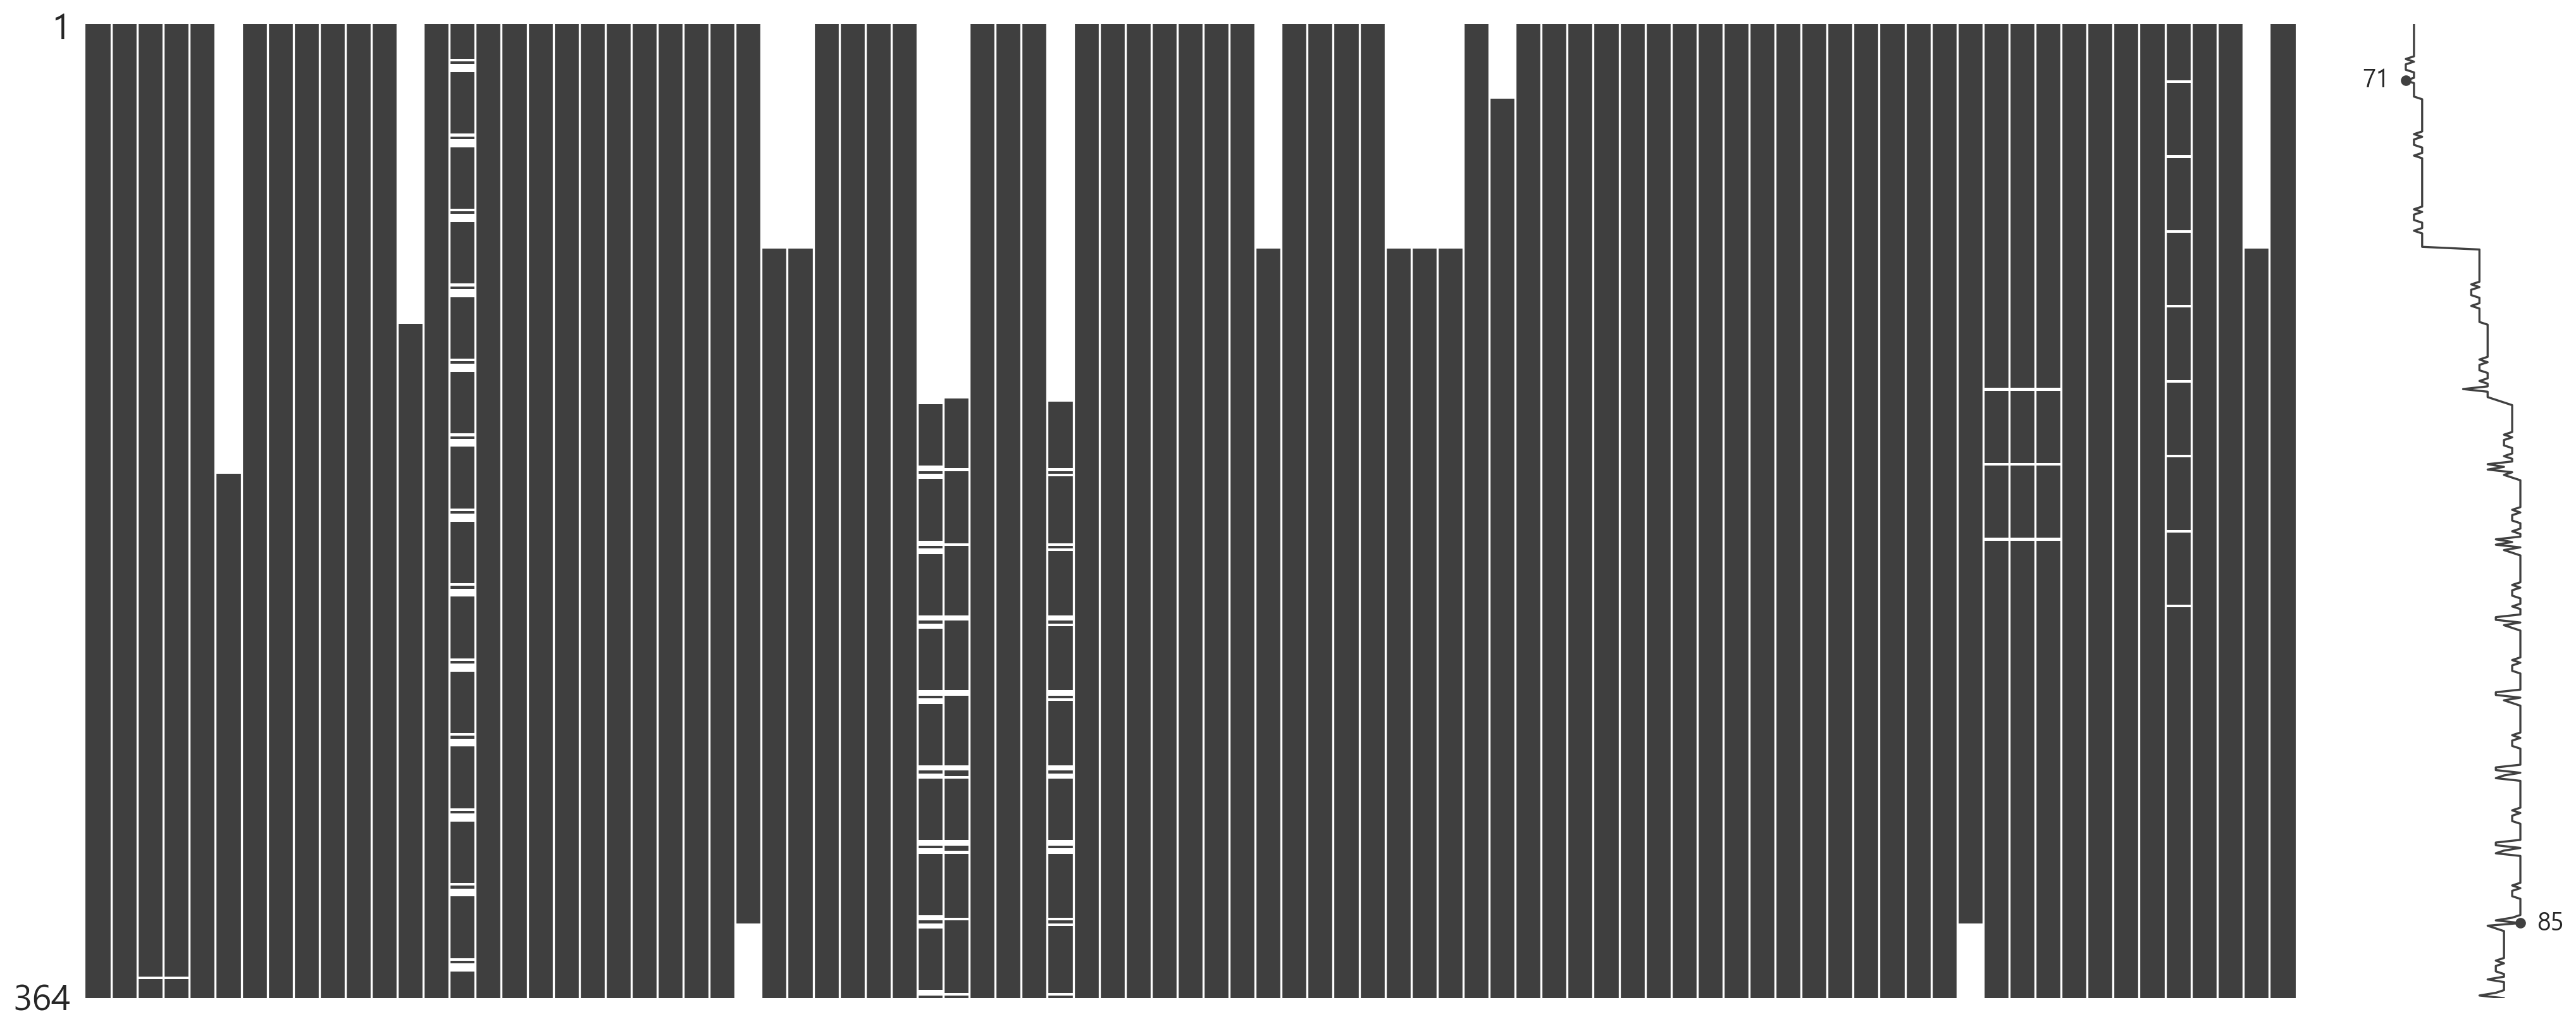

In [17]:
import missingno as msno
# msno.matrix(x_train)

# 결측치 채우려 할 경우 평균으로 간단하게 채워볼 수 있음
# x_train = x_train.apply(lambda x: x.fillna(x.mean()),axis=0)

msno.matrix(x_train)

In [61]:
#Random Forest Regressor

cities_rfc = RandomForestRegressor(n_estimators=100,oob_score=True,random_state=42)
cities_rfc.fit(x_train,y_train.values.ravel())

cities_pred_train = cities_rfc.predict(x_train)
cities_pred_test = cities_rfc.predict(x_test)

print('train mse: ' ,metrics.mean_squared_error(cities_pred_train,y_train))
print('test mse: ' ,metrics.mean_squared_error(cities_pred_test,y_test))

train mse:  6.3888164978122886
test mse:  299.2856006624797


In [64]:
# train의 y값 평균만 줬을때보단 얼마나 나을까?
print('baseline: ' ,metrics.mean_squared_error([y_train.mean()] * 91,y_test))

baseline:  505.3360953234369


<Axes: >

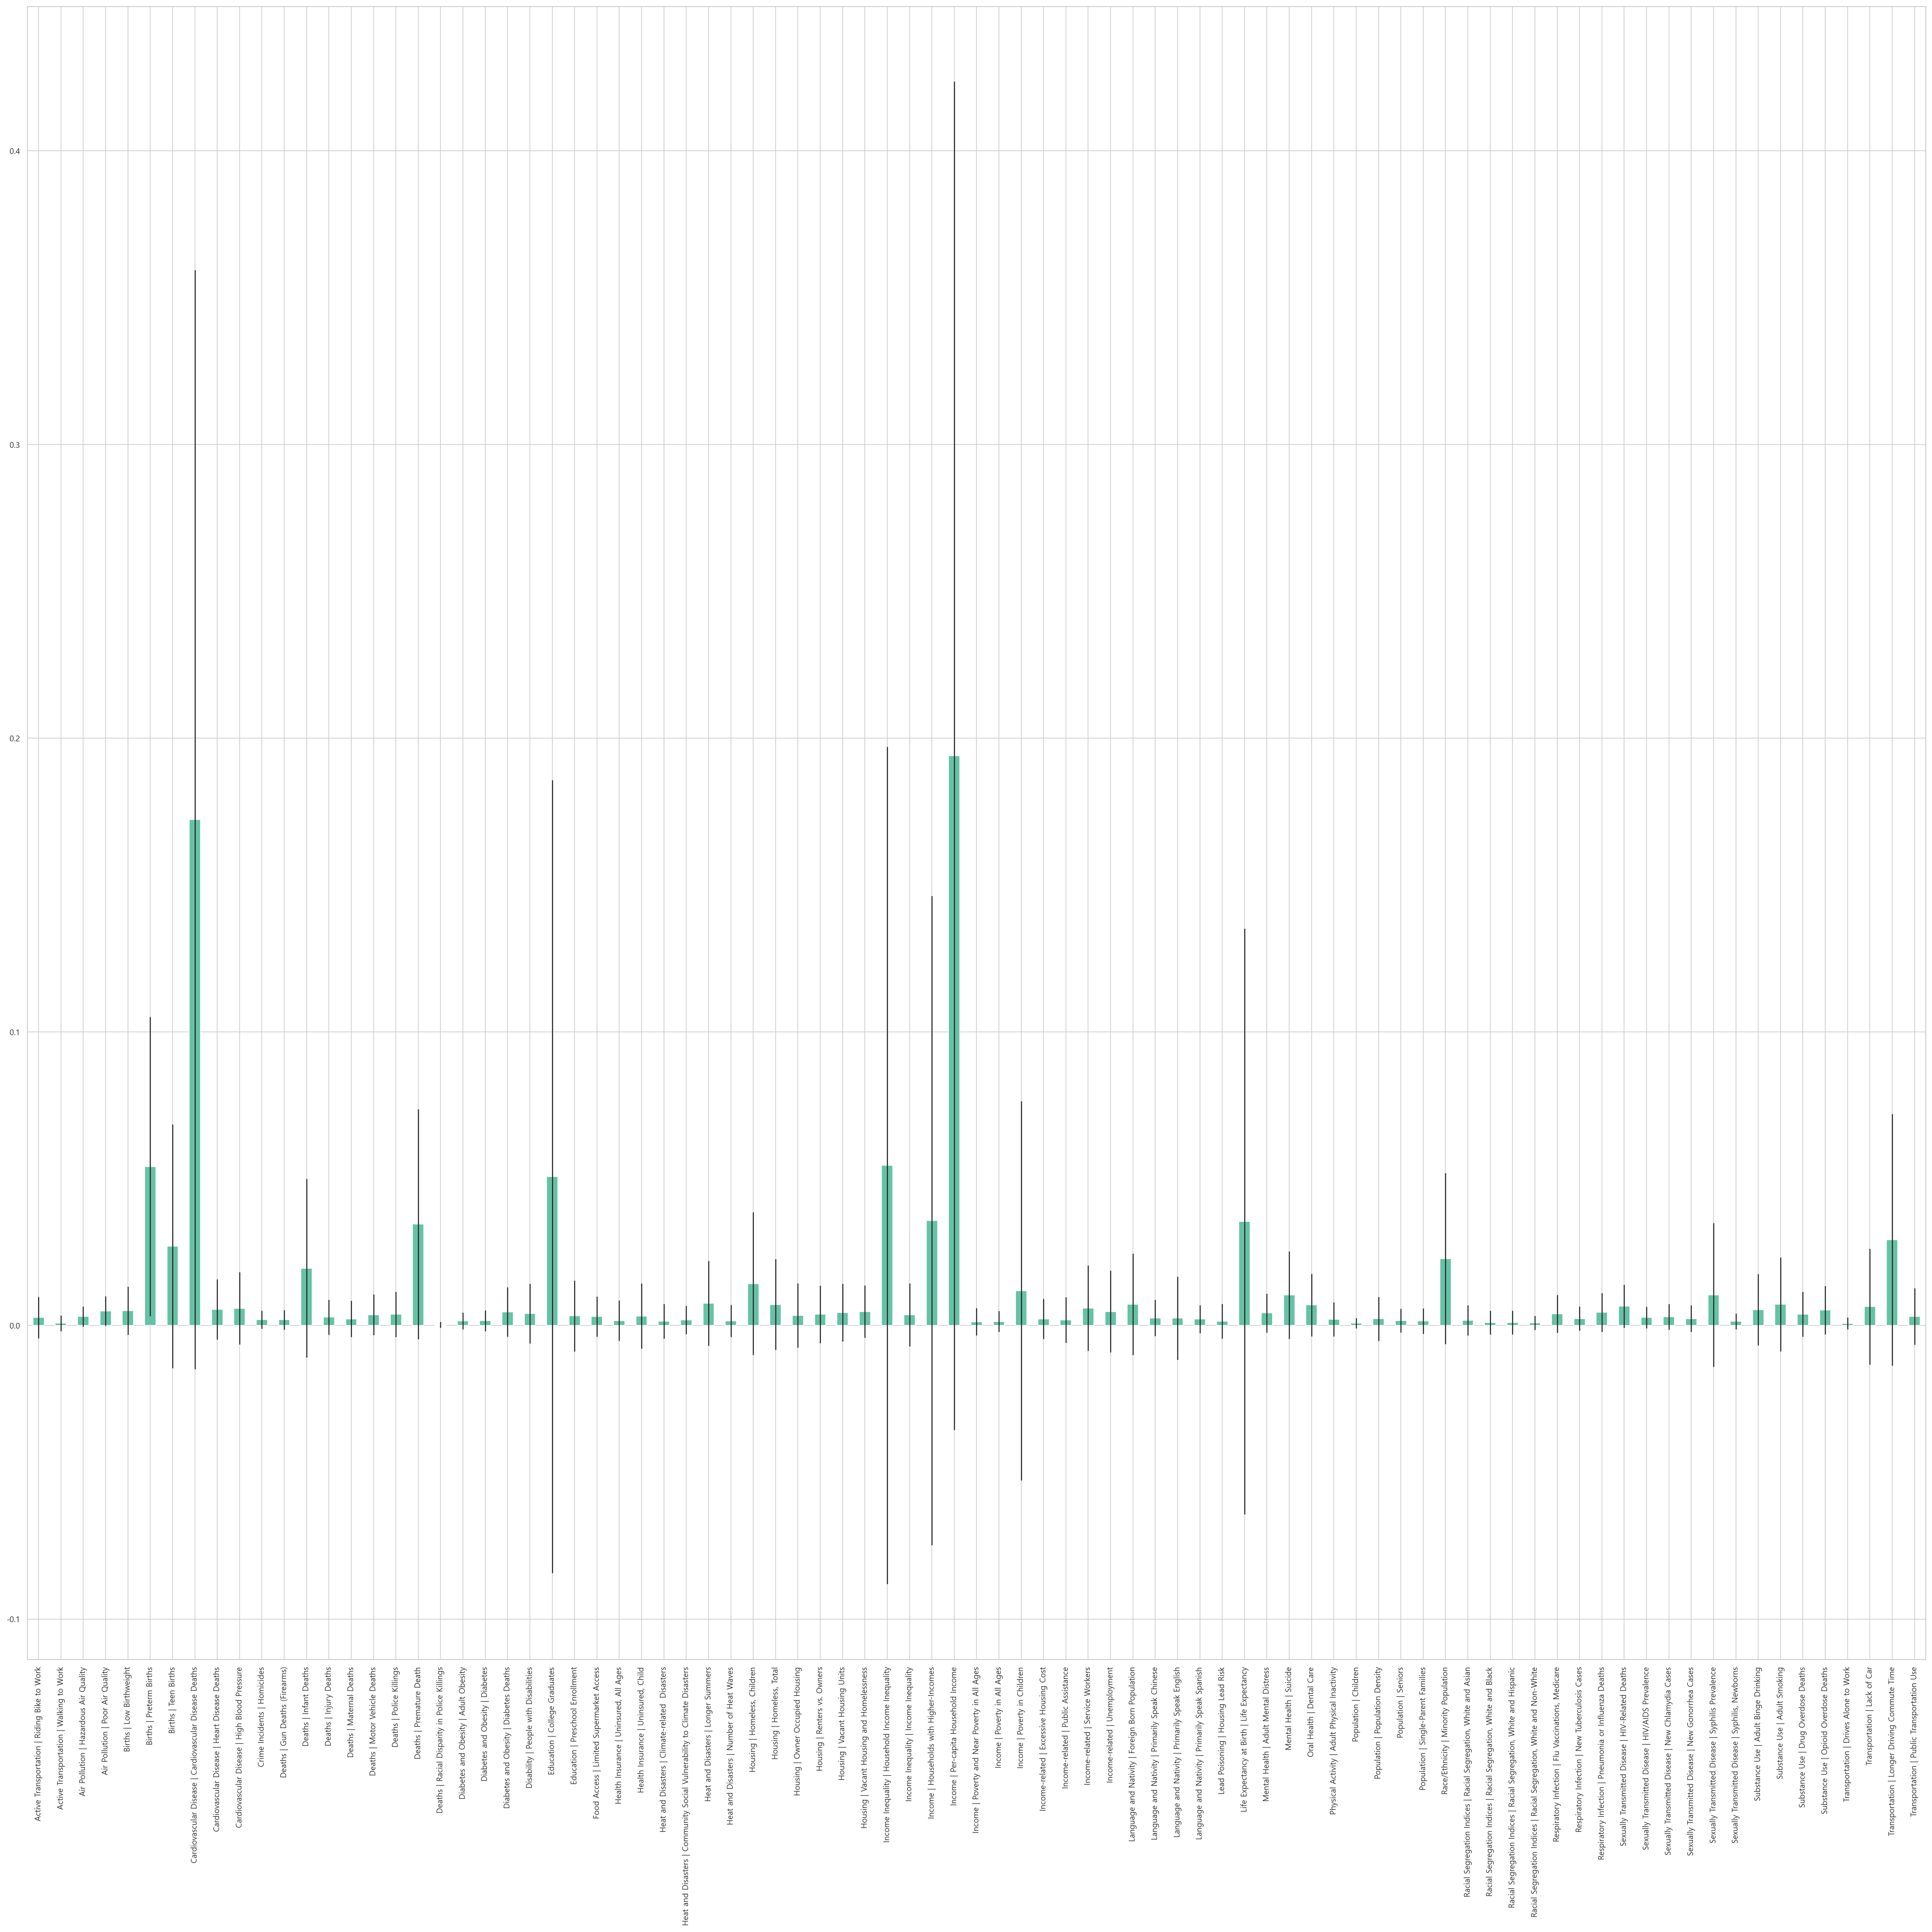

In [23]:
#feature importance 계산
importance = cities_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in cities_rfc.estimators_], axis=0)

forest_importance = pd.Series(importance, index=x_train.columns)

fig ,ax = plt.subplots(figsize=(30,30))
forest_importance.plot.bar(yerr=std,ax=ax)

In [65]:
def threshold(p):
    return np.quantile(forest_importance,p).item()

In [68]:
df_importance = forest_importance.to_frame()

#95%
display(df_importance[df_importance[0] > threshold(0.95)])
#90%
display(df_importance[df_importance[0] > threshold(0.9)])
#10%
display(df_importance[df_importance[0] < threshold(0.1)])
#5%
display(df_importance[df_importance[0] < threshold(0.05)])

,0
Births | Preterm Births,0.054103
Cardiovascular Disease | Cardiovascular Disease Deaths,0.172326
Education | College Graduates,0.050718
Income Inequality | Household Income Inequality,0.054497
Income | Per-capita Household Income,0.194010


,0
Births | Preterm Births,0.054103
Cardiovascular Disease | Cardiovascular Disease Deaths,0.172326
Deaths | Premature Death,0.034486
Education | College Graduates,0.050718
Income Inequality | Household Income Inequality,0.054497
Income | Households with Higher-Incomes,0.035742
Income | Per-capita Household Income,0.194010
Life Expectancy at Birth | Life Expectancy,0.035409
Transportation | Longer Driving Commute Time,0.029215


,0
Active Transportation | Walking to Work,0.000738
Deaths | Racial Disparity in Police Killings,0.000272
Income | Poverty and Near Poverty in All Ages,0.001252
Income | Poverty in All Ages,0.001380
Population | Children,0.000765
"Racial Segregation Indices | Racial Segregation, White and Black",0.001000
"Racial Segregation Indices | Racial Segregation, White and Hispanic",0.000985
"Racial Segregation Indices | Racial Segregation, White and Non-White",0.000904
Transportation | Drives Alone to Work,0.000706


,0
Active Transportation | Walking to Work,0.000738
Deaths | Racial Disparity in Police Killings,0.000272
Population | Children,0.000765
"Racial Segregation Indices | Racial Segregation, White and Non-White",0.000904
Transportation | Drives Alone to Work,0.000706


In [69]:
#지워볼만한 항목들
df_importance.index[df_importance[0] < threshold(0.1)]

Index(['Active Transportation | Walking to Work',
       'Deaths | Racial Disparity in Police Killings',
       'Income | Poverty and Near Poverty in All Ages',
       'Income | Poverty in All Ages', 'Population | Children',
       'Racial Segregation Indices | Racial Segregation, White and Black',
       'Racial Segregation Indices | Racial Segregation, White and Hispanic',
       'Racial Segregation Indices | Racial Segregation, White and Non-White',
       'Transportation | Drives Alone to Work'],
      dtype='object')

In [70]:
#위의 항목들 지우고 다시 하려면 여기 코드로 데이터 다시 정립
# avoid_list += df_importance.index[df_importance[0] < threshold(0.1)].to_list()

# x_train = train_scaled.loc[:,~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_list) | train_scaled.columns.isin(city_info))]#features_list]
# y_train = train[target_list]

# x_test = test_scaled.loc[:,~(test_scaled.columns.isin(avoid_list) | test_scaled.columns.isin(target_list) | test_scaled.columns.isin(city_info))]#features_list]
# y_test = test[target_list]

In [75]:
#heuristic하게 고른 항목들로만 하면 얼마나 나을까?

heuristic_list = ["Cancer | Breast Cancer Deaths",
"Cancer | Prostate Cancer Deaths",
"Physical Activity | Adult Physical Inactivity",
"Diabetes and Obesity | Diabetes",
"Diabetes and Obesity | Teen Obesity",
"Diabetes and Obesity | Adult Obesity",
"Dietary Quality | Teen Soda",
"Population | Seniors",
"Health Insurance | Uninsured, All Ages",
"Births | Low Birthweight",
"Births | Prenatal Care",
"Births | Preterm Births",
"Births | Teen Births",
"Income | Poverty in All Ages"]

x_train = x_train = train_scaled.loc[:,train_scaled.columns.isin(heuristic_list) & ~(train_scaled.columns.isin(avoid_list))]#features_list]
y_train = train[target_list]

x_test = test_scaled.loc[:,test_scaled.columns.isin(heuristic_list) & ~(test_scaled.columns.isin(avoid_list))]#features_list]
y_test = test[target_list]

In [80]:
# msno.matrix(x_train)
# x_train = x_train.apply(lambda x: x.fillna(x.mean()),axis=0)

In [81]:
cities_rfc = RandomForestRegressor(n_estimators=100,oob_score=True,random_state=42)
cities_rfc.fit(x_train,y_train.values.ravel())

cities_pred_train = cities_rfc.predict(x_train)
cities_pred_test = cities_rfc.predict(x_test)

print('train mse: ' ,metrics.mean_squared_error(cities_pred_train,y_train))
print('test mse: ' ,metrics.mean_squared_error(cities_pred_test,y_test))
print('baseline: ' ,metrics.mean_squared_error([y_train.mean()] * 91,y_test))

train mse:  11.951711933162072
test mse:  458.5267078727211
baseline:  505.3360953234369


<Axes: >

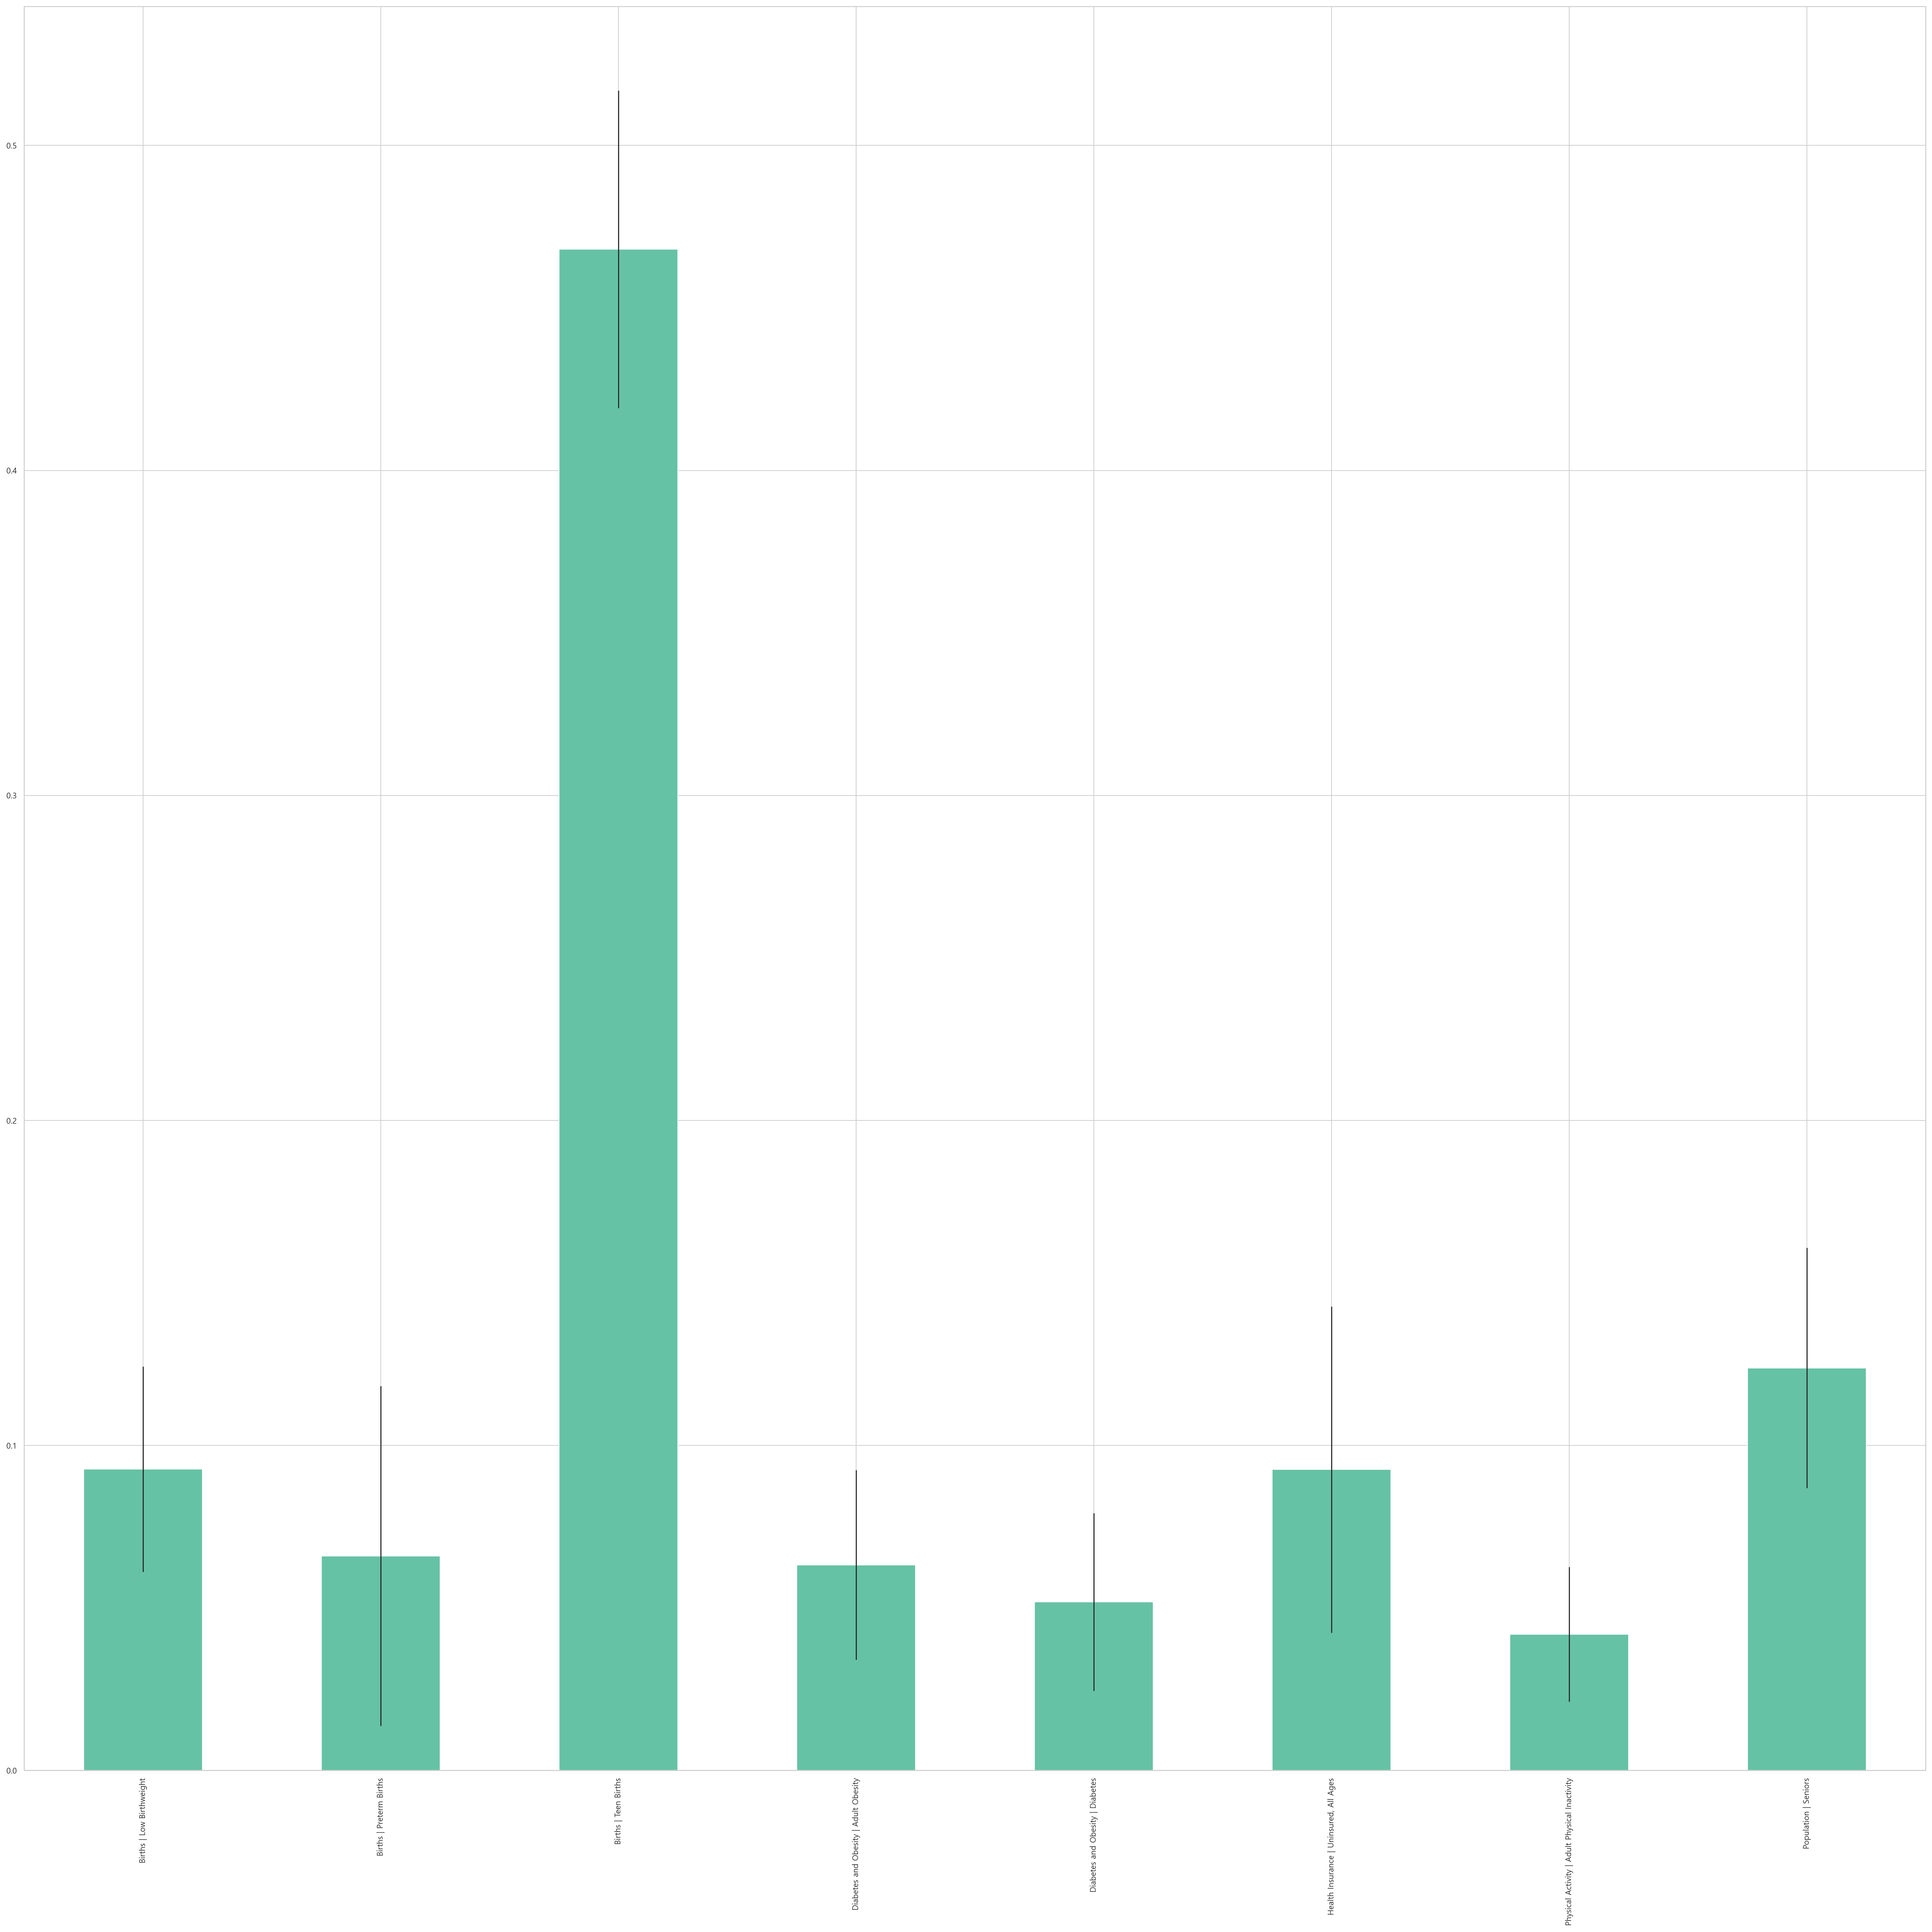

In [82]:
importance = cities_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in cities_rfc.estimators_], axis=0)

forest_importance = pd.Series(importance, index=x_train.columns)

fig ,ax = plt.subplots(figsize=(30,30))
forest_importance.plot.bar(yerr=std,ax=ax)

In [78]:
df_importance = forest_importance.to_frame()

#95%
display(df_importance[df_importance[0] > threshold(0.95)])
#90%
display(df_importance[df_importance[0] > threshold(0.9)])
#10%
display(df_importance[df_importance[0] < threshold(0.1)])
#5%
display(df_importance[df_importance[0] < threshold(0.05)])

,0
Births | Teen Births,0.434389


,0
Births | Teen Births,0.434389


,0
Physical Activity | Adult Physical Inactivity,0.042022


,0
Physical Activity | Adult Physical Inactivity,0.042022
